In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

# Preprocess the Data

## 1. Simple EDA + Data Quality checking

In [2]:
df = pd.read_csv("./Data/final_data.csv")

In [3]:
df.shape

(7136, 17)

In [4]:
df.head()

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value
0,Manchester United,Defender Centre-Back,175.0,25,82,0.028090,0.056180,0.224719,0.0000,0.0,0.0,0.0,6408,175,22,9,50000000
1,Manchester United,Defender Centre-Back,194.0,30,68,0.037799,0.000000,0.302394,0.0189,0.0,0.0,0.0,4762,148,27,1,25000000
2,Manchester United,Defender Centre-Back,187.0,28,70,0.000000,0.032901,0.115153,0.0000,0.0,0.0,0.0,5471,95,19,10,15000000
3,Manchester United,Defender Centre-Back,186.0,21,34,0.000000,0.000000,0.130529,0.0000,0.0,0.0,0.0,2758,47,13,0,2000000
4,Manchester United,Defender Left-Back,169.0,23,89,0.012619,0.063096,0.227145,0.0000,0.0,0.0,0.0,7132,182,15,3,22000000


In [5]:
df.dtypes

team                    object
position                object
height                 float64
age                      int64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
dtype: object

In [6]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['team', 'position']

numeric_features = [
    'height', 'age', 'appearance', 'goals', 'assists', 'yellow cards',
    'second yellow cards', 'red cards', 'goals conceded', 'clean sheets',
    'minutes played', 'days_injured', 'games_injured', 'award'
]


In [7]:
for i in categorical_features:
    print(df[i].value_counts())

team
Royal AM FC             36
Daegu FC                34
Al-Batin FC             34
Swallows FC             33
Maritzburg United FC    33
                        ..
FC Barcelona             5
Gaziantep FK             4
Manchester City          4
Bayern Munich            2
Real Madrid              1
Name: count, Length: 374, dtype: int64
position
Defender Centre-Back          1387
midfield-CentralMidfield       893
Attack Centre-Forward          774
Defender Right-Back            685
midfield-DefensiveMidfield     680
Defender Left-Back             643
midfield-AttackingMidfield     563
Attack-RightWinger             529
Attack-LeftWinger              490
Goalkeeper                     188
midfield-RightMidfield          79
midfield-LeftMidfield           77
midfield                        51
Attack-SecondStriker            41
Attack                          32
Defender                        24
Name: count, dtype: int64


In [8]:
# Calculate the frequency of each 'team'
team_counts = df['team'].value_counts()

# Filter 'team' values that appear 2 or more times
df = df[df['team'].isin(team_counts[team_counts >= 2].index)]

In [9]:
df.shape

(7135, 17)

## 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [10]:
categorical_features

['team', 'position']

In [11]:
df = pd.get_dummies(df, columns=categorical_features)

In [12]:
df.shape

(7135, 404)

In [13]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,175.0,25,82,0.028090,0.05618,0.224719,0.0000,0.0,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
1,194.0,30,68,0.037799,0.00000,0.302394,0.0189,0.0,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False


In [14]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_value(price):
    if price < p35:
        return 'Cheap_Value'
    elif price < p75:
        return 'Good_Value'
    else:
        return 'High_Value'

# Apply the function to create a new column
df['current_value_category'] = df['current_value'].apply(categorize_value)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['current_value_category'].value_counts())

current_value_category
Good_Value     2758
Cheap_Value    2455
High_Value     1922
Name: count, dtype: int64


In [15]:
p35, p75

(450000.0, 2500000.0)

In [ ]:
# df['current_value_category']

In [16]:
encoder = LabelEncoder()
df['current_value_category_encoded'] = encoder.fit_transform(df['current_value_category']) 

## 3. Feature selection

In [17]:
correlation = df.corr(numeric_only=True)
print(correlation['current_value_category_encoded'].sort_values(ascending=False))

current_value_category_encoded    1.000000
appearance                        0.524974
minutes played                    0.515136
games_injured                     0.268086
assists                           0.267793
                                    ...   
team_Richards Bay FC             -0.072991
team_Royal AM FC                 -0.079439
position_Attack                  -0.079658
position_midfield                -0.098564
position_Goalkeeper              -0.169420
Name: current_value_category_encoded, Length: 404, dtype: float64


In [18]:
# Set the correlation threshold
threshold = 0.23  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value_category_encoded']) > threshold]['current_value_category_encoded'].index
selected_features

Index(['appearance', 'assists', 'minutes played', 'games_injured', 'award',
       'current_value_category_encoded'],
      dtype='object')

In [19]:
selected_features = ['appearance', 'assists', 'minutes played', 'award', 'current_value_category_encoded']

In [20]:
df = df[selected_features]
df.head()

,appearance,assists,minutes played,award,current_value_category_encoded
0,82,0.056180,6408,9,2
1,68,0.000000,4762,1,2
2,70,0.032901,5471,10,2
3,34,0.000000,2758,0,1
4,89,0.063096,7132,3,2


## 4. Prepare train and test data

In [21]:
# Prepare data
X = df.drop(['current_value_category_encoded'], axis=1)

# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
X.shape

(7135, 4)

# Buliding the Model

In [25]:
wcss = []
for i in range(1, 20):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

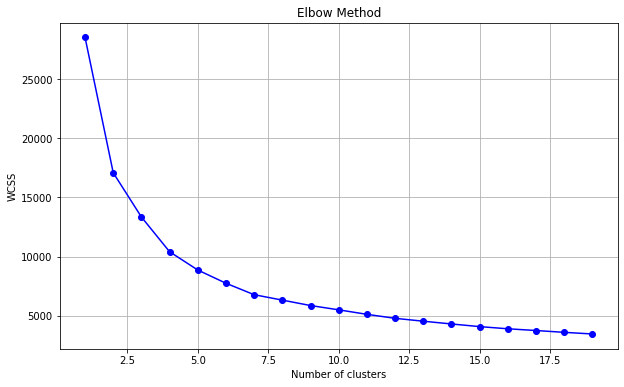

In [26]:
# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [27]:
# Optional: Apply k-Means using the optimal number of clusters
optimal_clusters = 7 # This might change based on your actual elbow curve analysis
model = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Train the Model and Test the Model


In [28]:
# Fit the model on the training data
y_pred = model.fit_predict(X_scaled)

# Evaluating the Model

In [29]:
X.head(2)

,appearance,assists,minutes played,award
0,82,0.05618,6408,9
1,68,0.00000,4762,1


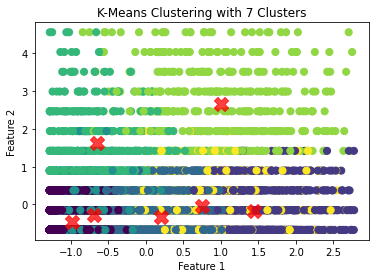

In [30]:
# Plotting the clusters with optimal number
plt.scatter(X_scaled[:, 2], X_scaled[:, 3], c=y_pred, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 3], c='red', s=200, alpha=0.75, marker='X')
plt.title(f'K-Means Clustering with {optimal_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [31]:
X['kmeans'] = y_pred

In [32]:
X['kmeans'].value_counts()

kmeans
0    2103
2    1518
1    1137
3     751
6     714
4     479
5     433
Name: count, dtype: int64

In [33]:
X[X['kmeans']==0]

,appearance,assists,minutes played,award,kmeans
24,25,0.000000,1465,0,0
89,13,0.000000,670,0,0
106,28,0.089731,1003,1,0
126,16,0.000000,1080,1,0
168,25,0.000000,1715,1,0
...,...,...,...,...,...
7128,32,0.000000,1268,0,0
7131,32,0.000000,1588,0,0
7132,16,0.087977,1023,0,0
7134,20,0.000000,960,0,0


<Axes: xlabel='appearance', ylabel='minutes played'>

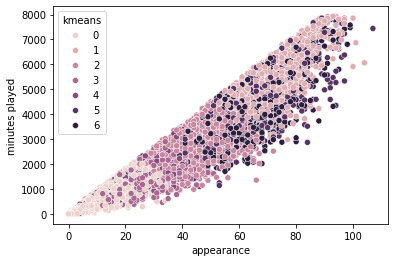

In [35]:
sns.scatterplot(data = X , x = 'appearance', y = 'minutes played', hue = 'kmeans')


<Axes: xlabel='appearance', ylabel='assists'>

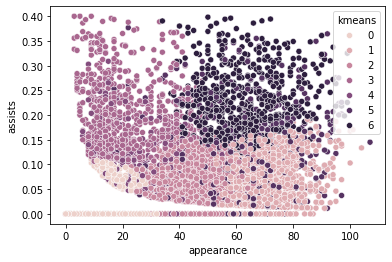

In [36]:
sns.scatterplot(data = X , x = 'appearance', y = 'assists', hue = 'kmeans')


<Axes: xlabel='appearance', ylabel='award'>

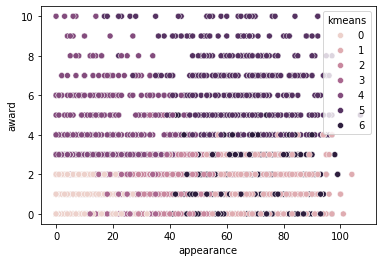

In [37]:
sns.scatterplot(data = X , x = 'appearance', y = 'award', hue = 'kmeans')
